# Model-Proxy Comparison @Antarctica

In [1]:
data_base_dir=f"/data44/kanon/kino2023grl"
model_miroc="MIROC5-iso"
model = model_miroc
print(model)

MIROC5-iso


In [2]:
# 基本となるモジュール
import os
import time
import datetime
import warnings
warnings.simplefilter("ignore")

# 数学・統計モジュール
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte

# データ操作・フォーマット
import xarray as xr
from netCDF4 import num2date
from netCDF4 import Dataset as NetCDFFile

# 描画・ビジュアル関連
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
from matplotlib.colors import rgb2hex
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.path as mpath

from cmocean import cm as cmo

# 地図関連
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
#from mpl_toolkits.basemap import Basemap

# その他のモジュール・ツール
import paramiko
from gtool3 import gtopen
from cdo import *
cdo = Cdo()
# オブジェクトコピー (Object copying)
from copy import copy
# Python cdo
# 自作モジュール
from read_gtool import read_gtool
gt = read_gtool() 
from read_netcdf import *
from command import command as cmd

# Jupyter Notebookの設定
%matplotlib ipympl
%matplotlib inline

# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False})


In [3]:
def read_exp_name(model):
    dic_exp_miroc = {
        
        "LGM_G": "LGM.glomap_anomtopo_t42.20230831",
        "LGM_M": "LGM.miroc_anomtopo_t42.20230831",
        "LGM_Mw/Gice": "LGM.miroc_glomapice_anomtopo_t42.20230831",
        "PI": "PI.AMIP_t42.20230831",
#        "PI_AMIP": "PI.AMIP_t42.20230831",
    }

    if model == "MIROC5-iso":
        return pd.DataFrame(dic_exp_miroc, index=["experimental_name"]).T
    else:
        raise ValueError("Invalid model name")

df_experiments_miroc = read_exp_name(model_miroc)

if model == model_miroc:
    df_experiments = df_experiments_miroc

# 新しい行を追加
df_experiments.loc['Proxy', 'experimental_name'] = 'Ice Core'

colno_pi =-2
colno_proxy=-1

colors = {
    "LGM_G":"orange",
    "LGM_M":  "magenta",
    "LGM_Mw/Gice": "purple",    
    "PI": "black",
    "Proxy":"gray"
}

markers = {
    "LGM_G": "o",
    "LGM_M": "s",
    "LGM_Mw/Gice": "t",    
    "PI": "^",
    "Proxy":"d"
}

# DataFrameに色を効率的に追加
df_experiments['color'] = df_experiments.index.map(colors)
df_experiments['marker'] = df_experiments.index.map(markers)

# 必要に応じてDataFrameを転置
df_experiments = df_experiments.T

In [4]:
colors_LGM_LGM = {
    f"SST effect (LGM_G - LGM_Mw/Gice)": "red",
    f"SIC effect (LGM_Mw/Gice - LGM_M)": "blue",
    f'both SST and SIC effect (LGM_G - LGM_M)': "black",
    f"Proxy": "gray"

}

# PI が含まれていない列に基づいて色を設定
colors_LGM_PI = {}

for col_name in df_experiments.columns:
    if "PI" not in col_name and col_name.lower() != "proxy":
        colors_LGM_PI[f"{col_name} - {df_experiments.columns[colno_pi]}"] = df_experiments.loc['color',col_name]

# 最後の列について色を設定
colors_LGM_PI[df_experiments.columns[colno_proxy]] = df_experiments.at['color', df_experiments.columns[colno_proxy]]
   

## Read data

### Proxies

In [5]:
csv_filename=f'{data_base_dir}/Antarctica_LGM_Proxies.csv'
df_reconst = pd.read_csv(csv_filename, index_col=0)
# df_reconst=df_reconst.drop(index="South Pole")
df_reconst["Site"]=df_reconst.index

### Model outputs

In [6]:
# 軸情報の読み込み
gtax = read_gtool()
gtax.dim="xy"
if model== model_miroc:
    gtax.var=f"{data_base_dir}/PI.AMIP_t42.20230831/clm/T2"

dlon, dlat, dlev = gtax.get_gtool_xyzaxis() # get axes 
# 軸の長さ
nlat, nlon = len(dlat),len(dlon)

In [7]:
variables_list=["T2","T2w","prcp_d18O","prcp_d18Oa"]

In [8]:
import os

def process_experiment_data(exp, base_dir=data_base_dir):
    ann_dir = f"{base_dir}/{exp}/clm/ann"
    cat_dir = f"{base_dir}/{exp}/cat/1dy"

    # T2wファイルの処理
    if not os.path.exists(f"{ann_dir}/T2w"):
        cmd(
            f"gtmlt {cat_dir}/T2 {cat_dir}/prcp out:{cat_dir}/T2xprcp > tmp.txt;"
            f"ngtavr {cat_dir}/T2xprcp -o {ann_dir}/T2xprcp;"
            f"gtdiv {ann_dir}/T2xprcp {ann_dir}/prcp out:{ann_dir}/T2w > tmp.txt;"
            f"rm tmp.txt {ann_dir}/T2xprcp"
        )

    # prcp_d18Oaファイルの処理
    if not os.path.exists(f"{ann_dir}/prcp_d18Oa"):   
        cmd(
            f"ngtavr {cat_dir}/prcp_d18O -o {ann_dir}/prcp_d18Oa"
        )

In [9]:
for exp in df_experiments.T["experimental_name"][:-1]:
    if exp.lower() != "proxy":
        process_experiment_data(exp)    
        for var in variables_list:
            var_gt = f"{data_base_dir}/{exp}/clm/ann/{var}"
            print(f"model_outputs/{exp}/clm/ann/{var}")
            
            if not os.path.exists(f"{var_gt}.nc"):
                cmd(f"ngtcf {var_gt} {var_gt}.nc") 
        

model_outputs/LGM.glomap_anomtopo_t42.20230831/clm/ann/T2
model_outputs/LGM.glomap_anomtopo_t42.20230831/clm/ann/T2w
model_outputs/LGM.glomap_anomtopo_t42.20230831/clm/ann/prcp_d18O
model_outputs/LGM.glomap_anomtopo_t42.20230831/clm/ann/prcp_d18Oa
model_outputs/LGM.miroc_anomtopo_t42.20230831/clm/ann/T2
model_outputs/LGM.miroc_anomtopo_t42.20230831/clm/ann/T2w
model_outputs/LGM.miroc_anomtopo_t42.20230831/clm/ann/prcp_d18O
model_outputs/LGM.miroc_anomtopo_t42.20230831/clm/ann/prcp_d18Oa
model_outputs/LGM.miroc_glomapice_anomtopo_t42.20230831/clm/ann/T2
model_outputs/LGM.miroc_glomapice_anomtopo_t42.20230831/clm/ann/T2w
model_outputs/LGM.miroc_glomapice_anomtopo_t42.20230831/clm/ann/prcp_d18O
model_outputs/LGM.miroc_glomapice_anomtopo_t42.20230831/clm/ann/prcp_d18Oa
model_outputs/PI.AMIP_t42.20230831/clm/ann/T2
model_outputs/PI.AMIP_t42.20230831/clm/ann/T2w
model_outputs/PI.AMIP_t42.20230831/clm/ann/prcp_d18O
model_outputs/PI.AMIP_t42.20230831/clm/ann/prcp_d18Oa


### Simulations

In [10]:
import numpy as np

def sampling(datasets_ref, grz_PI, datasets, grz_LGM, 
             df_model):
    
    # 列をゼロで初期化
    cols = [
        "mgrad_aa", "mgrad_ww", "mgrad_wa", "mgrad_aw", 
        "md18O_a", "mtemp_a", "md18O_w", "mtemp_w",
        "mprcp_PI", "mprcp_LGM", "mtemp_aa", "mtemp_ww", 
        "mtemp_wa", "mtemp_aw", "mgrz_PI", "mgrz_LGM", "mgrz_anom"
    ]
    df_model[cols] = 0

    # 有限緯度でフィルタリング
    idx = np.isfinite(df_model["lat"])
    filtered_df = df_model[idx]

    for i, row in filtered_df.iterrows():
        lon_index = np.abs(dlon[:-1] - row["lon"]).argmin()
        lat_index = np.abs(dlat[:] - row["lat"]).argmin()
        
        # 単純化された計算
        df_model.loc[i, ["mgrz_PI", "mgrz_LGM"]] = [grz_PI[lat_index, lon_index], grz_LGM[lat_index, lon_index]]
        df_model.at[i, "mgrz_anom"] = df_model.at[i, "mgrz_LGM"] - df_model.at[i, "mgrz_PI"]

        deltas = {
            "md18O_a": datasets["prcp_d18Oa"] - datasets_ref["prcp_d18Oa"],
            "mtemp_a": datasets["T2"] - datasets_ref["T2"],
            "md18O_w": datasets["prcp_d18O"] - datasets_ref["prcp_d18O"],
            "mtemp_w": datasets["T2w"] - datasets_ref["T2w"]
        }

        for key, value in deltas.items():
            df_model.at[i, key] = value[lat_index, lon_index]

        # 勾配と温度の計算
        mgrad_values = {
            "aa": ("md18O_a", "mtemp_a"),
            "aw": ("md18O_a", "mtemp_w"),
            "wa": ("md18O_w", "mtemp_a"),
            "ww": ("md18O_w", "mtemp_w")
        }
        for key, (d18O, temp) in mgrad_values.items():
            df_model.at[i, f"mgrad_{key}"] = df_model.at[i, d18O] / df_model.at[i, temp]
            df_model.at[i, f"mtemp_{key}"] = 1 / df_model.at[i, f"mgrad_{key}"] * df_model.at[i, "dd18O"]

    return df_model.dropna(how="any")


In [11]:
def read_files(input_directory, file_type="gtool"):
    if file_type == "gtool":
        return read_gtool_files(input_directory)
    elif file_type == "netcdf":
        return read_netcdf_files(input_directory)
    else:
        raise ValueError("Unsupported file type")

def read_gtool_files(input_directory):
    gt.dim="xy"
    gt.var = f"{input_directory}/T2"
    T2 = gt.gtopen() - 273.15
    gt.var = f"{input_directory}/T2w"
    T2w = gt.gtopen() - 273.15
    gt.var = f"{input_directory}/prcp_d18O"
    prcp_d18O = gt.gtopen()
    gt.var = f"{input_directory}/prcp_d18Oa"
    prcp_d18Oa = gt.gtopen()
    return T2, T2w, prcp_d18O, prcp_d18Oa

def read_netcdf_files(input_directory):
    T2 = read_single_netcdf(f"{input_directory}/T2.nc", anom=-273.15,warnings=False)
    T2w = read_single_netcdf(f"{input_directory}/T2w.nc", anom=-273.15,warnings=False)
    prcp_d18O = read_single_netcdf(f"{input_directory}/prcp_d18O.nc",warnings=False)
    prcp_d18Oa = read_single_netcdf(f"{input_directory}/prcp_d18Oa.nc",warnings=False)
    return T2, T2w, prcp_d18O, prcp_d18Oa

def read_single_netcdf(file_path, anom=0, coef=1,warnings=True):
    var_name = cmd(f"cdo -s -showname {file_path}").strip()
    return read_single_file(file_path, var_name, cyclic=True, anom=anom, coef=1, dlon0=dlon[:-1],warnings=warnings).squeeze()
    
def save_or_read_files(datasets, exp_label, exp_label_ref, sampling_func, suffix, grz_PI, grz_LGM,base_dir=data_base_dir):
    csv_path = f"{base_dir}/{df_experiments[exp_label]['experimental_name']}/Ant_proxymap_{suffix}.csv"
    df_model = sampling_func(
        datasets[exp_label_ref], grz_PI, 
        datasets[exp_label], grz_LGM,
        df_reconst[["lat","lon","dd18O"]])
    df_model.to_csv(csv_path)
    
    return df_model    

In [12]:
datasets = {}
for exp_label in df_experiments.columns[:-1]:
    if exp_label.lower() != "proxy":
        print(exp_label)
        expname=df_experiments[exp_label]["experimental_name"]
        T2, T2w, prcp_d18O, prcp_d18Oa = read_files(
            f'{data_base_dir}/{expname}/clm/ann', 
            file_type="gtool")
        datasets[exp_label] = {"T2":T2, "T2w":T2w, 
                       "prcp_d18O":prcp_d18O,
                           "prcp_d18Oa":prcp_d18Oa}

LGM_G
LGM_M
LGM_Mw/Gice
PI


In [13]:
# Read topography
BC_dir=data_base_dir
gt.var= f"{BC_dir}/grz.t42"
gt.dim = "xy"
grz_PI = gt.gtopen() 
gt.var = f"{BC_dir}/grz.t42_lgm"
grz_LGM = gt.gtopen()

# Get axes
dlon, dlat, dlev = gt.get_gtool_xyzaxis()

In [14]:
grlndf_LGM = get_model_BC(model,"grlndf", res="t42", model_echam="ECHAM6_wiso", model_miroc=model_miroc, era="LGM")
grlndf_PI = get_model_BC(model,"grlndf", res="t42", model_echam="ECHAM6_wiso", model_miroc=model_miroc, era="PI")

In [15]:
# Read model variables

dfs = []

for exp_label in df_experiments.columns:
    if "pi" not in exp_label.lower() and exp_label.lower() != "proxy":
        expname=df_experiments[exp_label]["experimental_name"]
        print(expname)
        df_model = save_or_read_files(datasets, exp_label, df_experiments.columns[colno_pi], sampling, "LGM-PI", grz_PI, grz_LGM)
        dfs.append(df_model)


for ii in range(len(dfs)):
    try:
        dfs[ii].drop(columns="dd18O", inplace=True)
    except:
        pass
    dfs[ii]["label"]= f"{df_experiments.columns[ii]} - {df_experiments.columns[colno_pi]}"
    dfs[ii]["Site"] = df_reconst.index.tolist()

# 各データフレームに'label'列を追加

df_reconst_d18O=df_reconst[["lat","lon","dd18O","Site"]]
df_reconst_d18O["label"]=df_experiments.columns[colno_proxy]
df_reconst_temp=df_reconst[["lat","lon","dtemp_W18","Site"]]
df_reconst_temp.rename(columns={"dtemp_W18": "dtemp"}, inplace=True)
df_reconst_temp["label"]=df_experiments.columns[colno_proxy]

LGM.glomap_anomtopo_t42.20230831
LGM.miroc_anomtopo_t42.20230831
LGM.miroc_glomapice_anomtopo_t42.20230831


In [16]:
def make_df(dfs, df_reconst, var="md18O_w", varo="dd18O"):
    # DataFrameを結合して、指定された変数をリネームする
    # 'label' 列が存在するかを確認
    df_model_combined = pd.concat([df[["Site","lat", "lon", var,"label"]] for df in dfs if 'label' in df.columns])
    df_combined = pd.concat([df_reconst.rename(columns={varo: var}), df_model_combined]).reset_index(drop=True)

    # 初期 DataFrame を設定
    base_df = dfs[0][["Site","lat", "lon"]]
    base_df["Site"] = df_reconst.index.tolist()

    df_model_LGManom_SST = base_df.copy()
    df_model_LGManom_SI = base_df.copy()
    df_model_LGManom_SISST = base_df.copy()

    # 計算とラベルの設定
    if len(dfs) > 2:
        try:
            idx_LGM_G = df_experiments.columns.get_loc("LGM_G")
            idx_LGM_Mw_Gice = df_experiments.columns.get_loc("LGM_Mw/Gice")
            idx_LGM_M = df_experiments.columns.get_loc("LGM_M")

            df_model_LGManom_SST[var] = dfs[idx_LGM_G][var] - dfs[idx_LGM_Mw_Gice][var]
            df_model_LGManom_SI[var] = dfs[idx_LGM_Mw_Gice][var] - dfs[idx_LGM_M][var]

            df_model_LGManom_SST["label"] = list(colors_LGM_LGM.keys())[0]
            df_model_LGManom_SI["label"] = list(colors_LGM_LGM.keys())[1]
        except KeyError:
            df_model_LGManom_SST = pd.DataFrame([])
            df_model_LGManom_SI = pd.DataFrame([])

    # LGM_M または LGM_T に基づく計算
    if "LGM_M" in df_experiments.columns or "LGM_T" in df_experiments.columns:
        col_LGM = "LGM_M" if "LGM_M" in df_experiments.columns else "LGM_T"
        idx_LGM = df_experiments.columns.get_loc(col_LGM)
        df_model_LGManom_SISST[var] = dfs[idx_LGM_G][var] - dfs[idx_LGM][var]
        df_model_LGManom_SISST["label"] = list(colors_LGM_LGM.keys())[2]
    else:
        df_model_LGManom_SISST = pd.DataFrame([])

    # 最終的な DataFrame を結合
    df_model_LGManom = pd.concat([df_model_LGManom_SST, df_model_LGManom_SI, df_model_LGManom_SISST]).reset_index(drop=True)

    return df_model_combined, df_combined, df_model_LGManom


In [17]:
def draw_bar(var, data, palette=dict(df_experiments.T["color"]), 
             return_fig=False, fig=None, ax=None, 
             ylim=(-5, 5),legend_ncol=2,
             legend=True, bbox_to_anchor=(.5, 1.1),x_label_size=9):
    label_map = {
        "dd18O": "$\mathsf{\Delta\delta^{18}O_{p}}$",
        "dtemp": "$\mathsf{\Delta T_a}$",
        "md18O_w": "$\mathsf{\Delta\delta^{18}O_{p}}$",  # (Simulated)
        "md18O_a": "$\mathsf{\Delta\delta^{18}O_a}$",  # (Simulated)
        "md18O_diff": "$\mathsf{\Delta\delta^{18}O_{p}} - \mathsf{\Delta\delta^{18}O_a}$",  # (Simulated)
        "mtemp_a": "$\mathsf{\Delta T_a}$",  # (Simulated)
        "mtemp_w": "$\mathsf{\Delta T_w}$"  # (Simulated)
    }
    unit_map = {
        "dd18O": "‰",
        "dtemp": "℃",
        "md18O_w": "‰",  # (Simulated)
        "md18O_a": "‰",  # (Simulated)
        "md18O_diff": "‰",  # (Simulated)
        "mtemp_a": "℃",  # (Simulated)
        "mtemp_w": "℃"  # (Simulated)
    }
    
    label = label_map.get(var, "")
    unit = unit_map.get(var, "")

    if not return_fig:
        fig, ax = plt.subplots(figsize=(10,2))
    sns.barplot(data=data, x="Site", y=var, hue="label", palette=palette, ax=ax)

    # Set zorder of bars
    for container in ax.containers:
        for patch in container.patches:
            patch.set_zorder(10)
            
    ax.set_ylim(ylim)  
    # Set y-axis limits and locators
    if not var.startswith("d"):      
        ax.yaxis.set_major_locator(MultipleLocator(2))
    else:
        ax.yaxis.set_major_locator(MultipleLocator(3))
    ax.yaxis.set_minor_locator(MultipleLocator(1))

    # Enable minor ticks on y-axis
    ax.tick_params(axis='y', which="major", left=True)  
    ax.set_xlabel("")
    ax.set_ylabel(f"[{unit}]")
    ax.yaxis.grid(True, which='both', linestyle='-', linewidth=0.5, zorder=-1)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=x_label_size)

    # Set legend
    if legend:
        ax.legend(loc='lower center', bbox_to_anchor=bbox_to_anchor, ncol=legend_ncol)
    elif ax.get_legend() is not None:
        ax.get_legend().remove()

    if return_fig:
        return fig, ax
    else:
        plt.show()

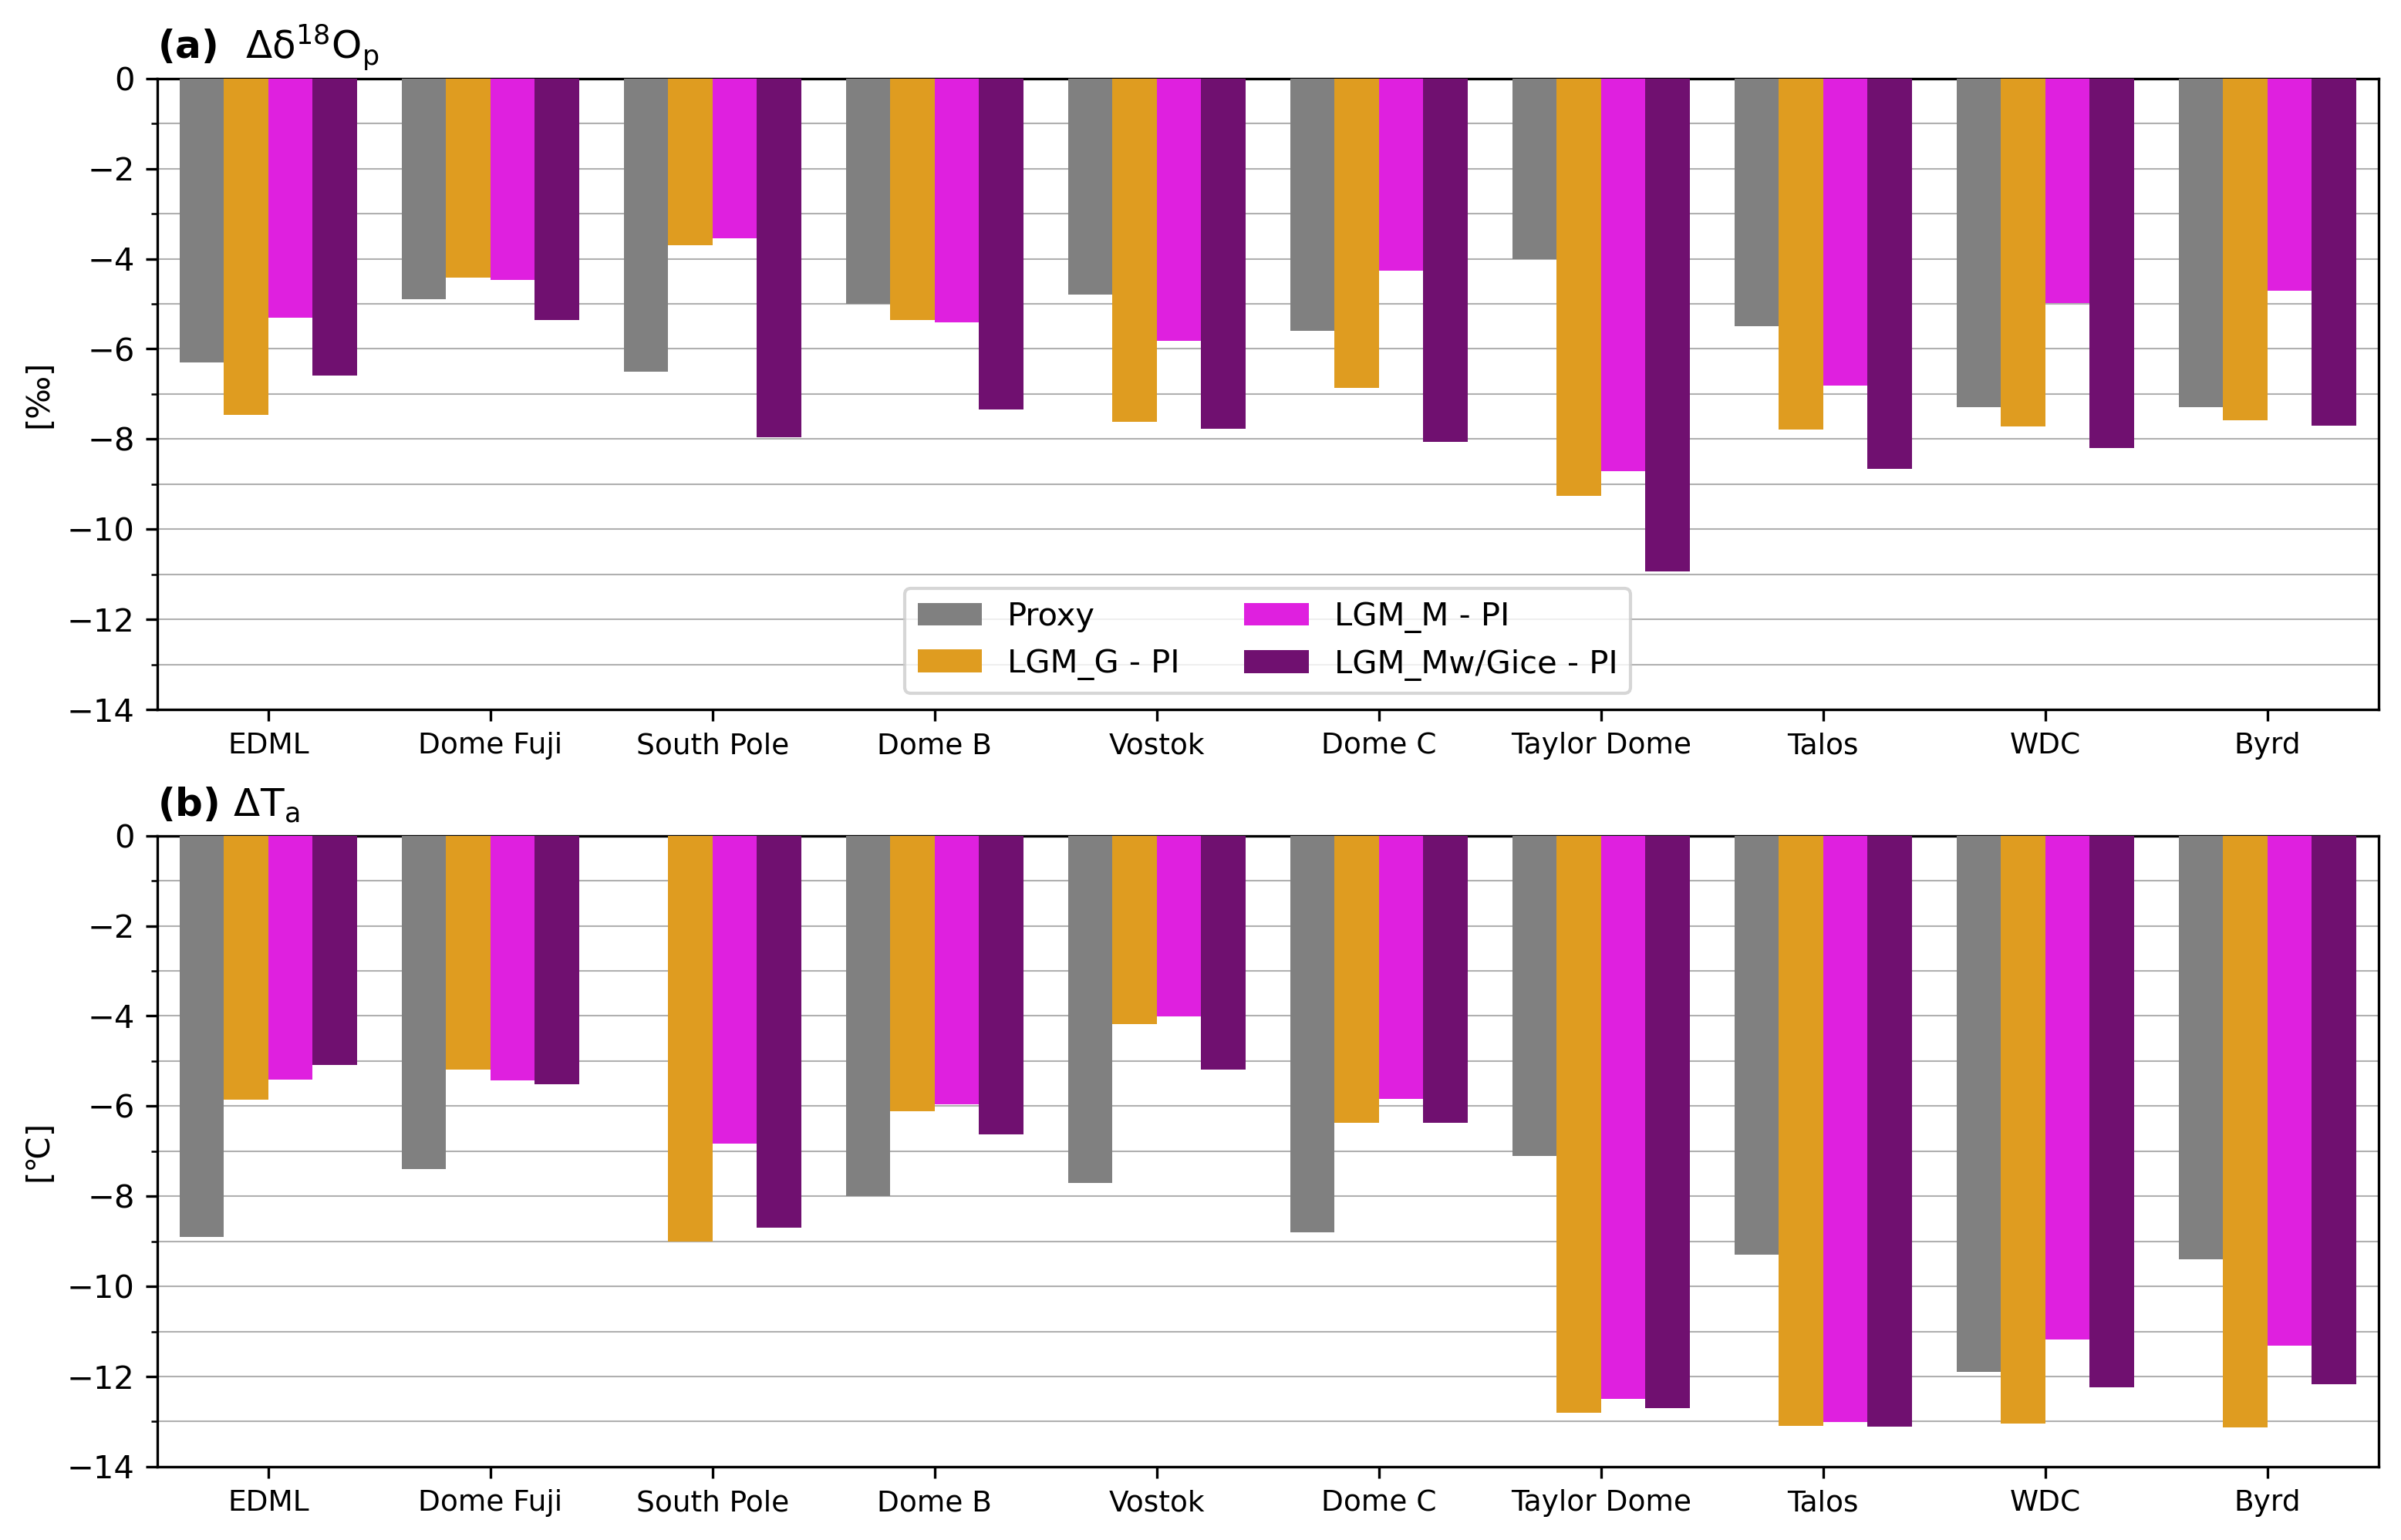

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
#fig, ax = plt.subplots(3,1, figsize=(10,10))
#fig.suptitle(model)

df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")

ax[0].set_title("(a)  $\mathsf{\Delta\delta^{18}O_{p}}$",loc="left",weight="demibold")
fig,ax[0] = draw_bar("md18O_w",df_combined, palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[0], bbox_to_anchor=(.5, 0),ylim=(-14,0))

#ax[2].set_title("(c)",loc="left",weight="demibold")
#fig,ax[2] = draw_bar("md18O_w",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[2], bbox_to_anchor=(.5, -0.3),ylim=(-5,5))
df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_temp, var="mtemp_a", varo="dtemp")

ax[1].set_title("(b) $\mathsf{\Delta T_a}$",loc="left",weight="demibold")
fig,ax[1] = draw_bar("mtemp_a",df_combined, palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[1],ylim=(-14,0),legend=False)
plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.2,wspace=0.05)

plt.show()

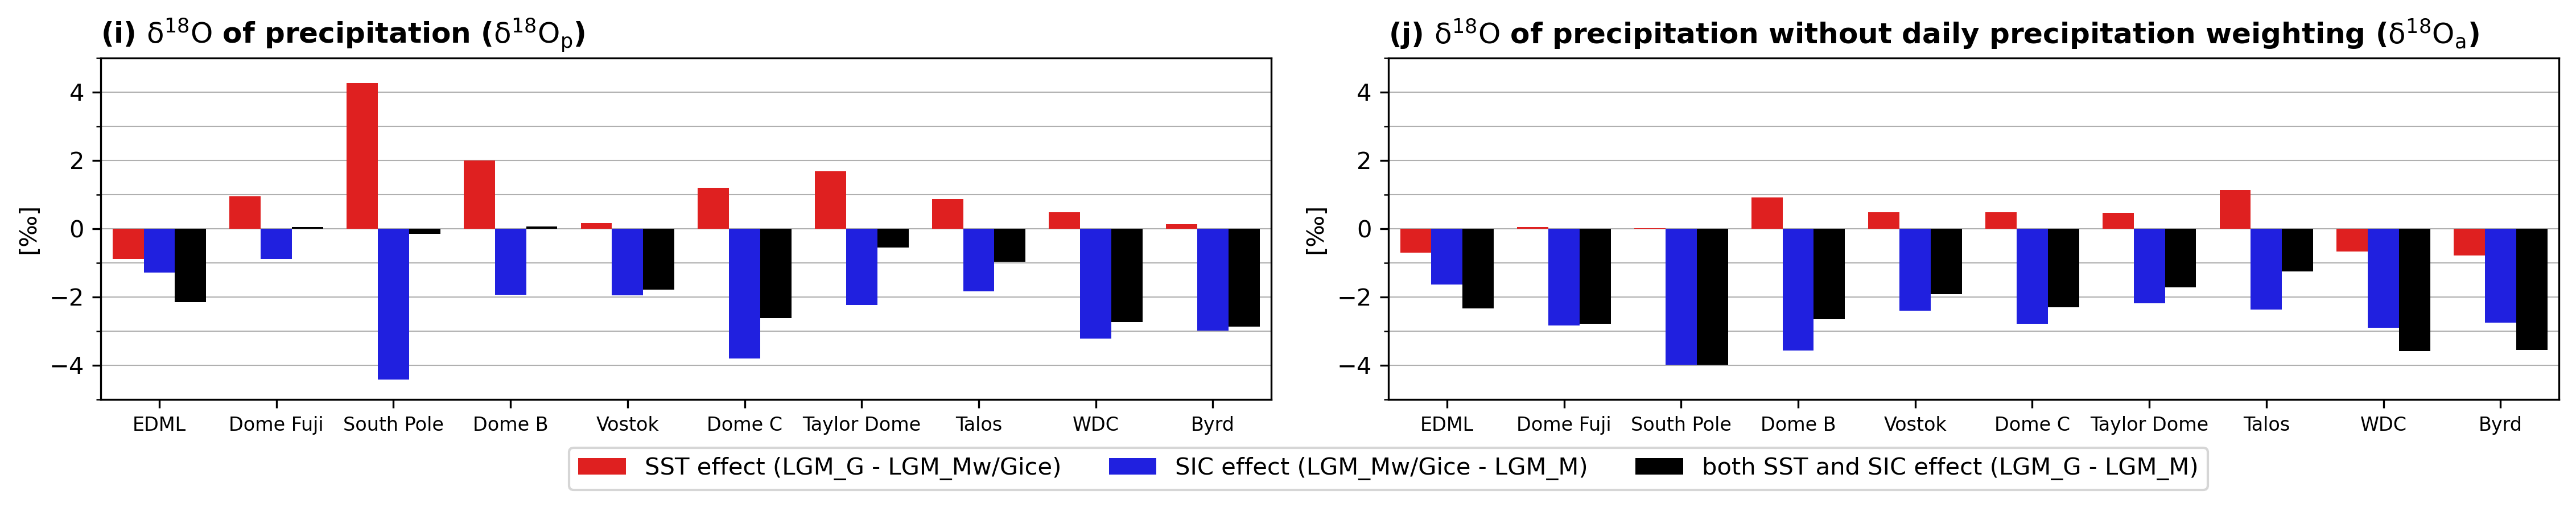

In [19]:
#fig, ax = plt.subplots(3,1, figsize=(10,10))
fig, ax = plt.subplots(1,2, figsize=(15,2))
#fig.suptitle(model)

_,_, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")

ax[0].set_title("(i) $\mathrm{\delta^{18}O}$ of precipitation ($\mathrm{\delta^{18}O_{p}}$)",loc="left",weight="demibold")
fig,ax[0] = draw_bar("md18O_w",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[0], legend=False,ylim=(-5,5),x_label_size=8)


_,_, df_model_LGManom_a=make_df(dfs, df_reconst_d18O, var="md18O_a", varo="dd18O")
ax[1].set_title("(j) $\mathrm{\delta^{18}O}$ of precipitation without daily precipitation weighting ($\mathrm{\delta^{18}O_{a}}$)",loc="left",weight="demibold")
fig,ax[1] = draw_bar("md18O_a",df_model_LGManom_a, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[1], legend_ncol=3,bbox_to_anchor=(0, -0.3),ylim=(-5,5),x_label_size=8)


# df_model_LGManom["md18O_diff"]=df_model_LGManom["md18O_w"]-df_model_LGManom_a["md18O_a"]
# ax[2].set_title("(c)",loc="left",weight="demibold")
# fig,ax[2] = draw_bar("md18O_diff",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[2], bbox_to_anchor=(.5, -0.3),ylim=(-5,5))

plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.15,wspace=0.1)

plt.show()

## For presentation

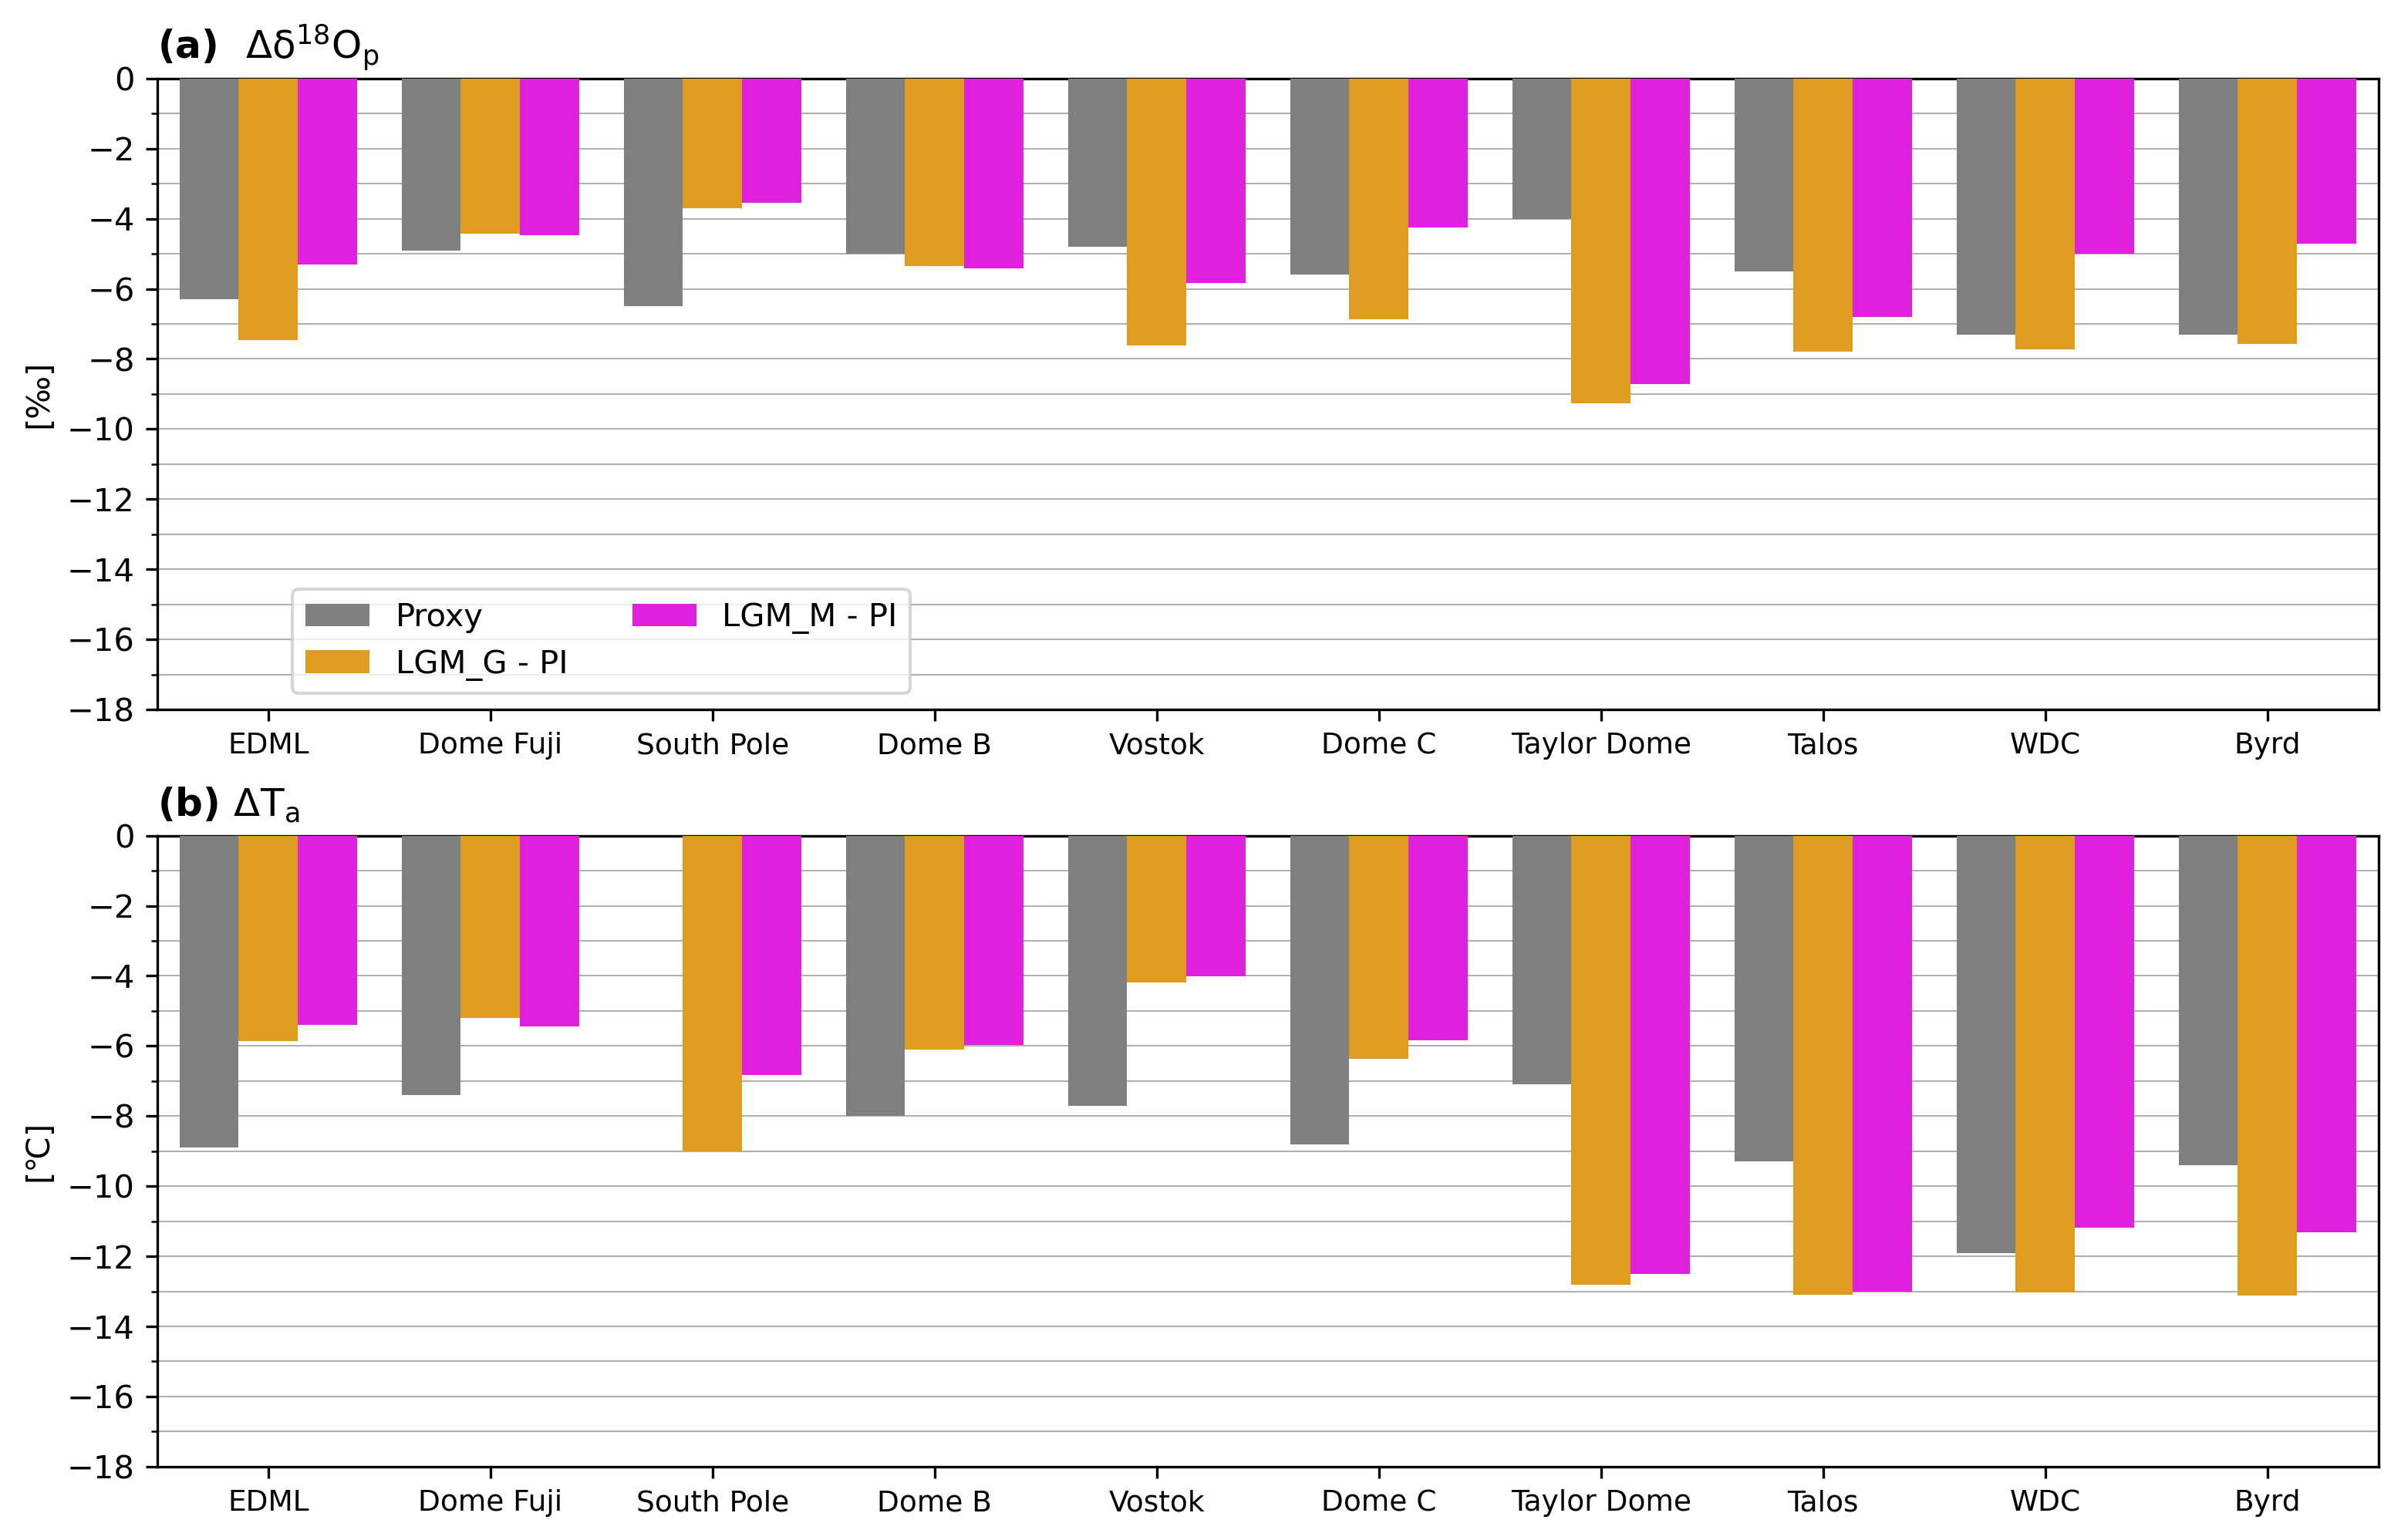

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
#fig, ax = plt.subplots(3,1, figsize=(10,10))
#fig.suptitle(model)

df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")

ax[0].set_title("(a)  $\mathsf{\Delta\delta^{18}O_{p}}$",loc="left",weight="demibold")
fig,ax[0] = draw_bar("md18O_w",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[0], bbox_to_anchor=(.2, 0),ylim=(-18,0))

#ax[2].set_title("(c)",loc="left",weight="demibold")
#fig,ax[2] = draw_bar("md18O_w",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[2], bbox_to_anchor=(.5, -0.3),ylim=(-5,5))
df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_temp, var="mtemp_a", varo="dtemp")

ax[1].set_title("(b) $\mathsf{\Delta T_a}$",loc="left",weight="demibold")
fig,ax[1] = draw_bar("mtemp_a",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[1],ylim=(-18,0),legend=False)

plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.2,wspace=0.05)

plt.show()

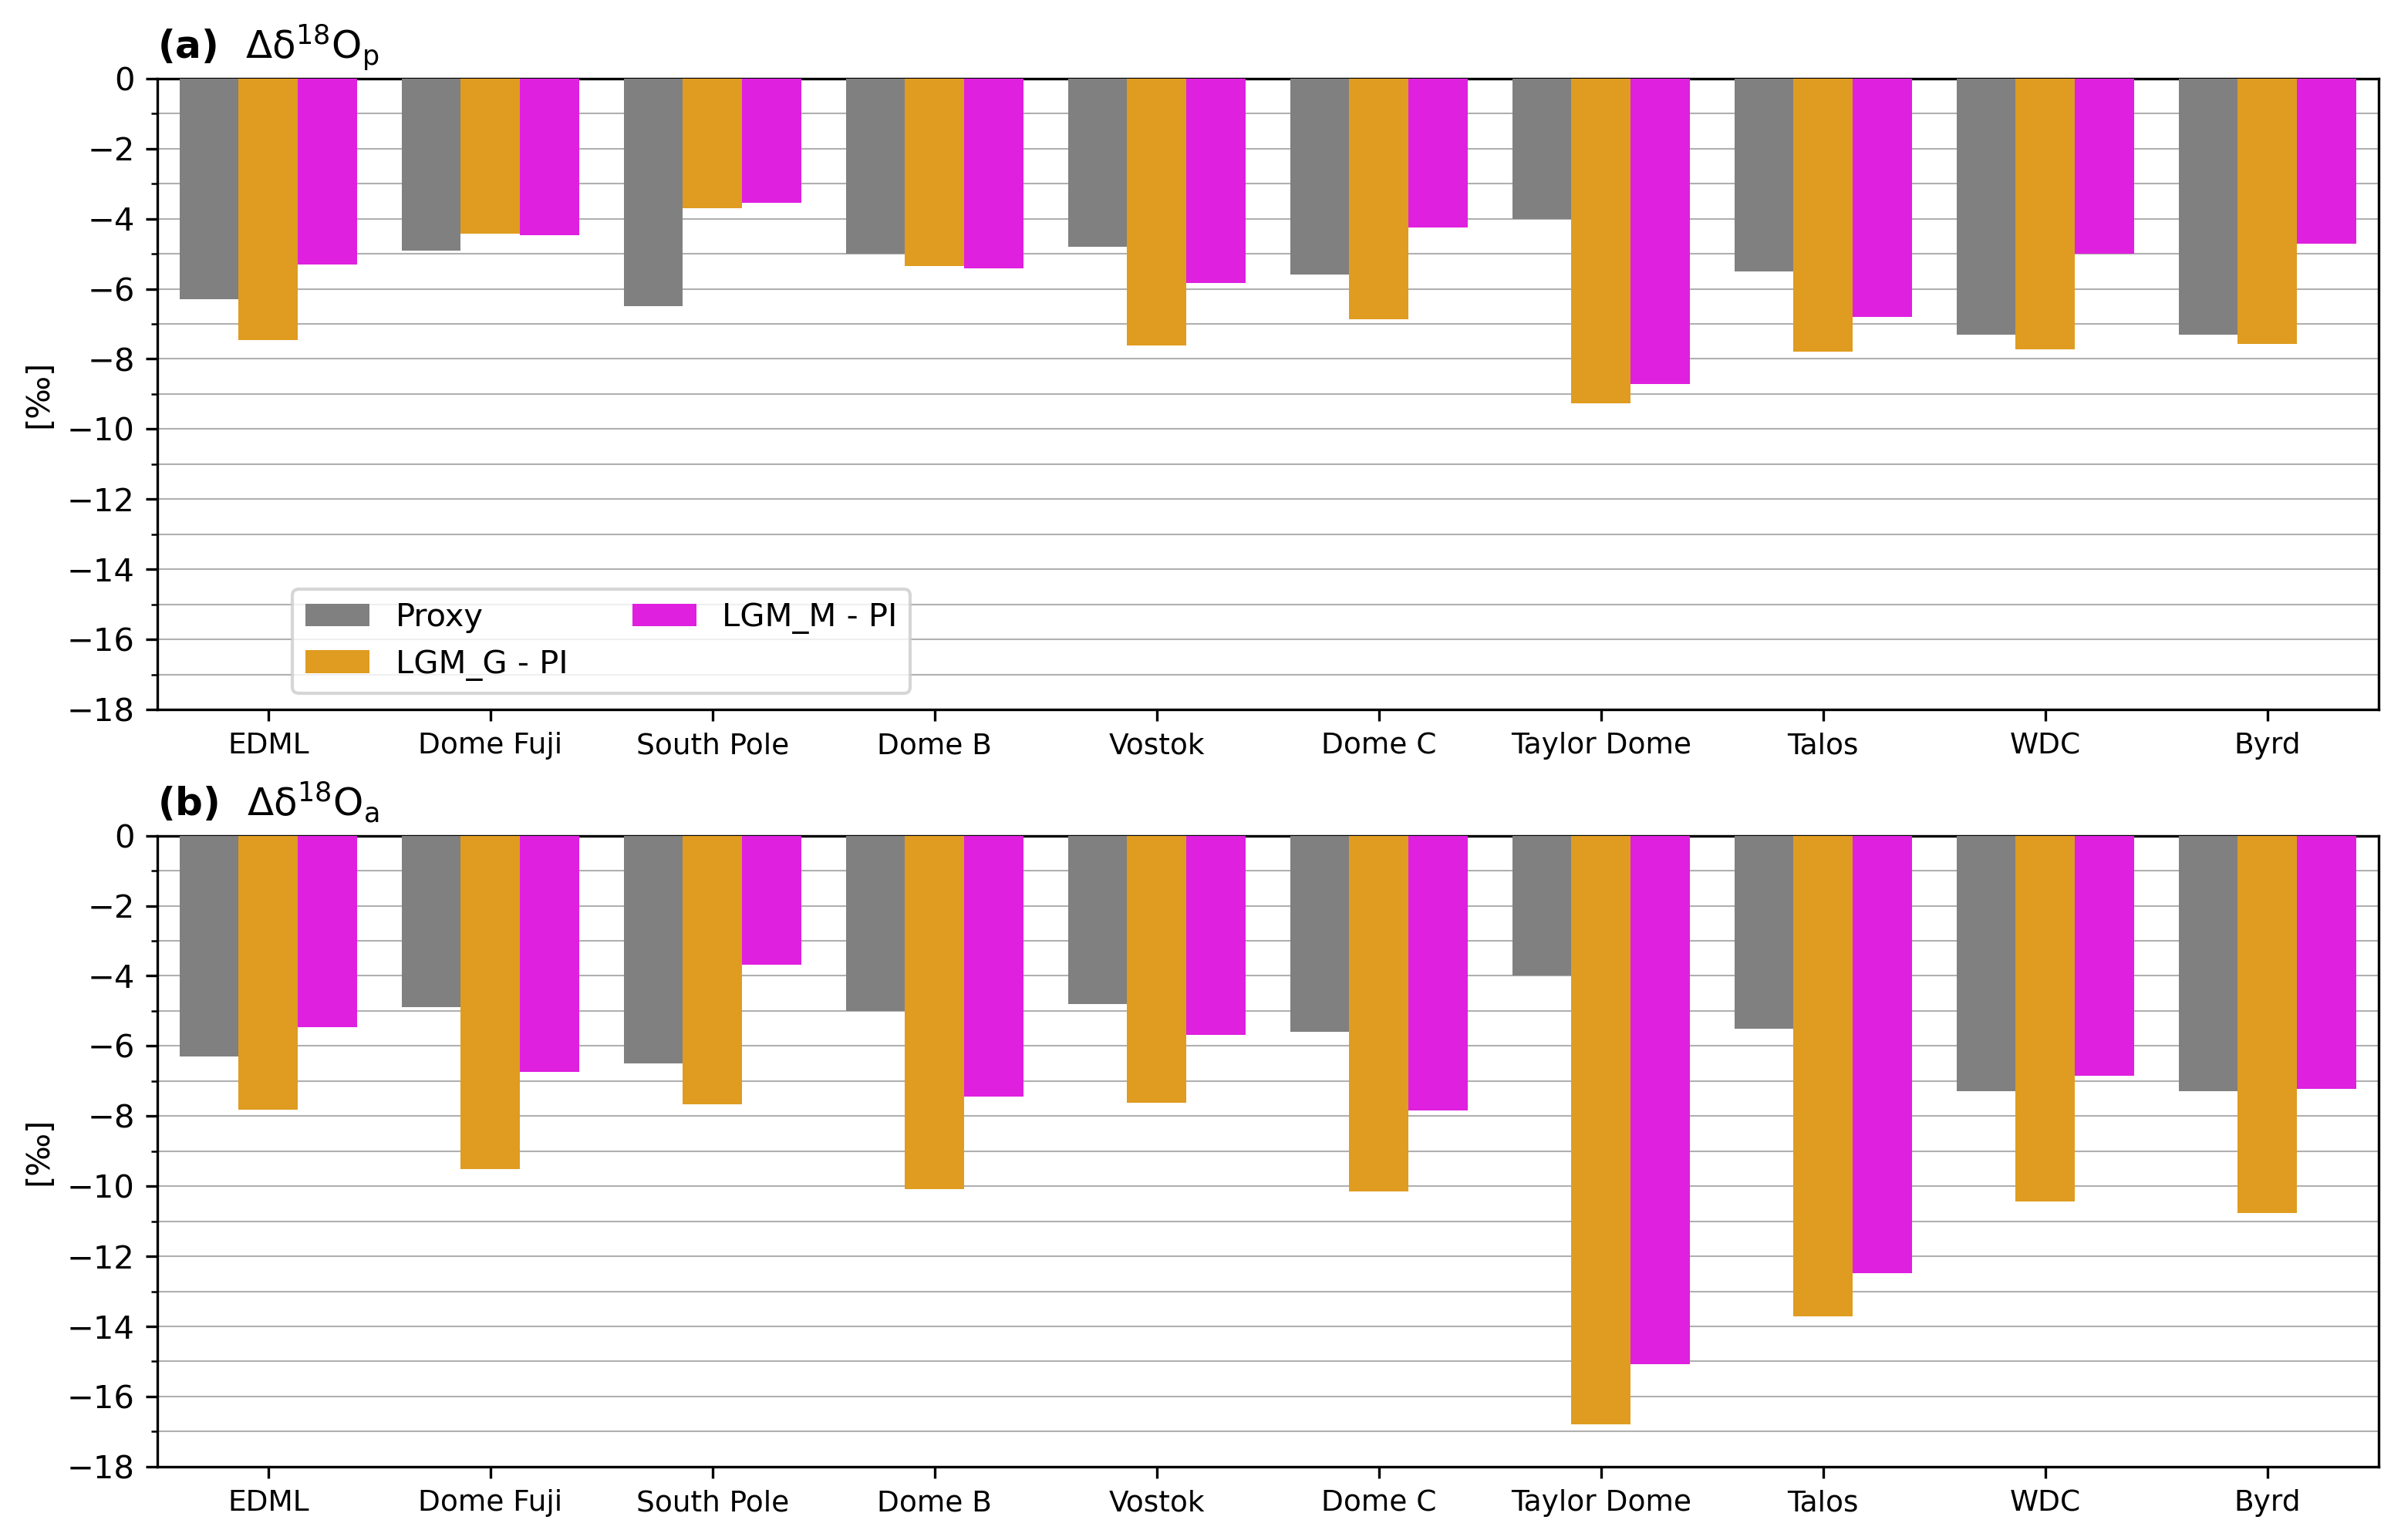

In [21]:
# For presentation
fig, ax = plt.subplots(2,1, figsize=(10,6))
#fig, ax = plt.subplots(3,1, figsize=(10,10))
#fig.suptitle(model)

df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")

ax[0].set_title("(a)  $\mathsf{\Delta\delta^{18}O_{p}}$",loc="left",weight="demibold")
fig,ax[0] = draw_bar("md18O_w",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[0], bbox_to_anchor=(.2, 0),ylim=(-18,0))

df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_a", varo="dd18O")

ax[1].set_title("(b)  $\mathsf{\Delta\delta^{18}O_{a}}$",loc="left",weight="demibold")
fig,ax[1] = draw_bar("md18O_a",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[1],ylim=(-18,0), legend=False)

plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.2,wspace=0.05)

plt.show()

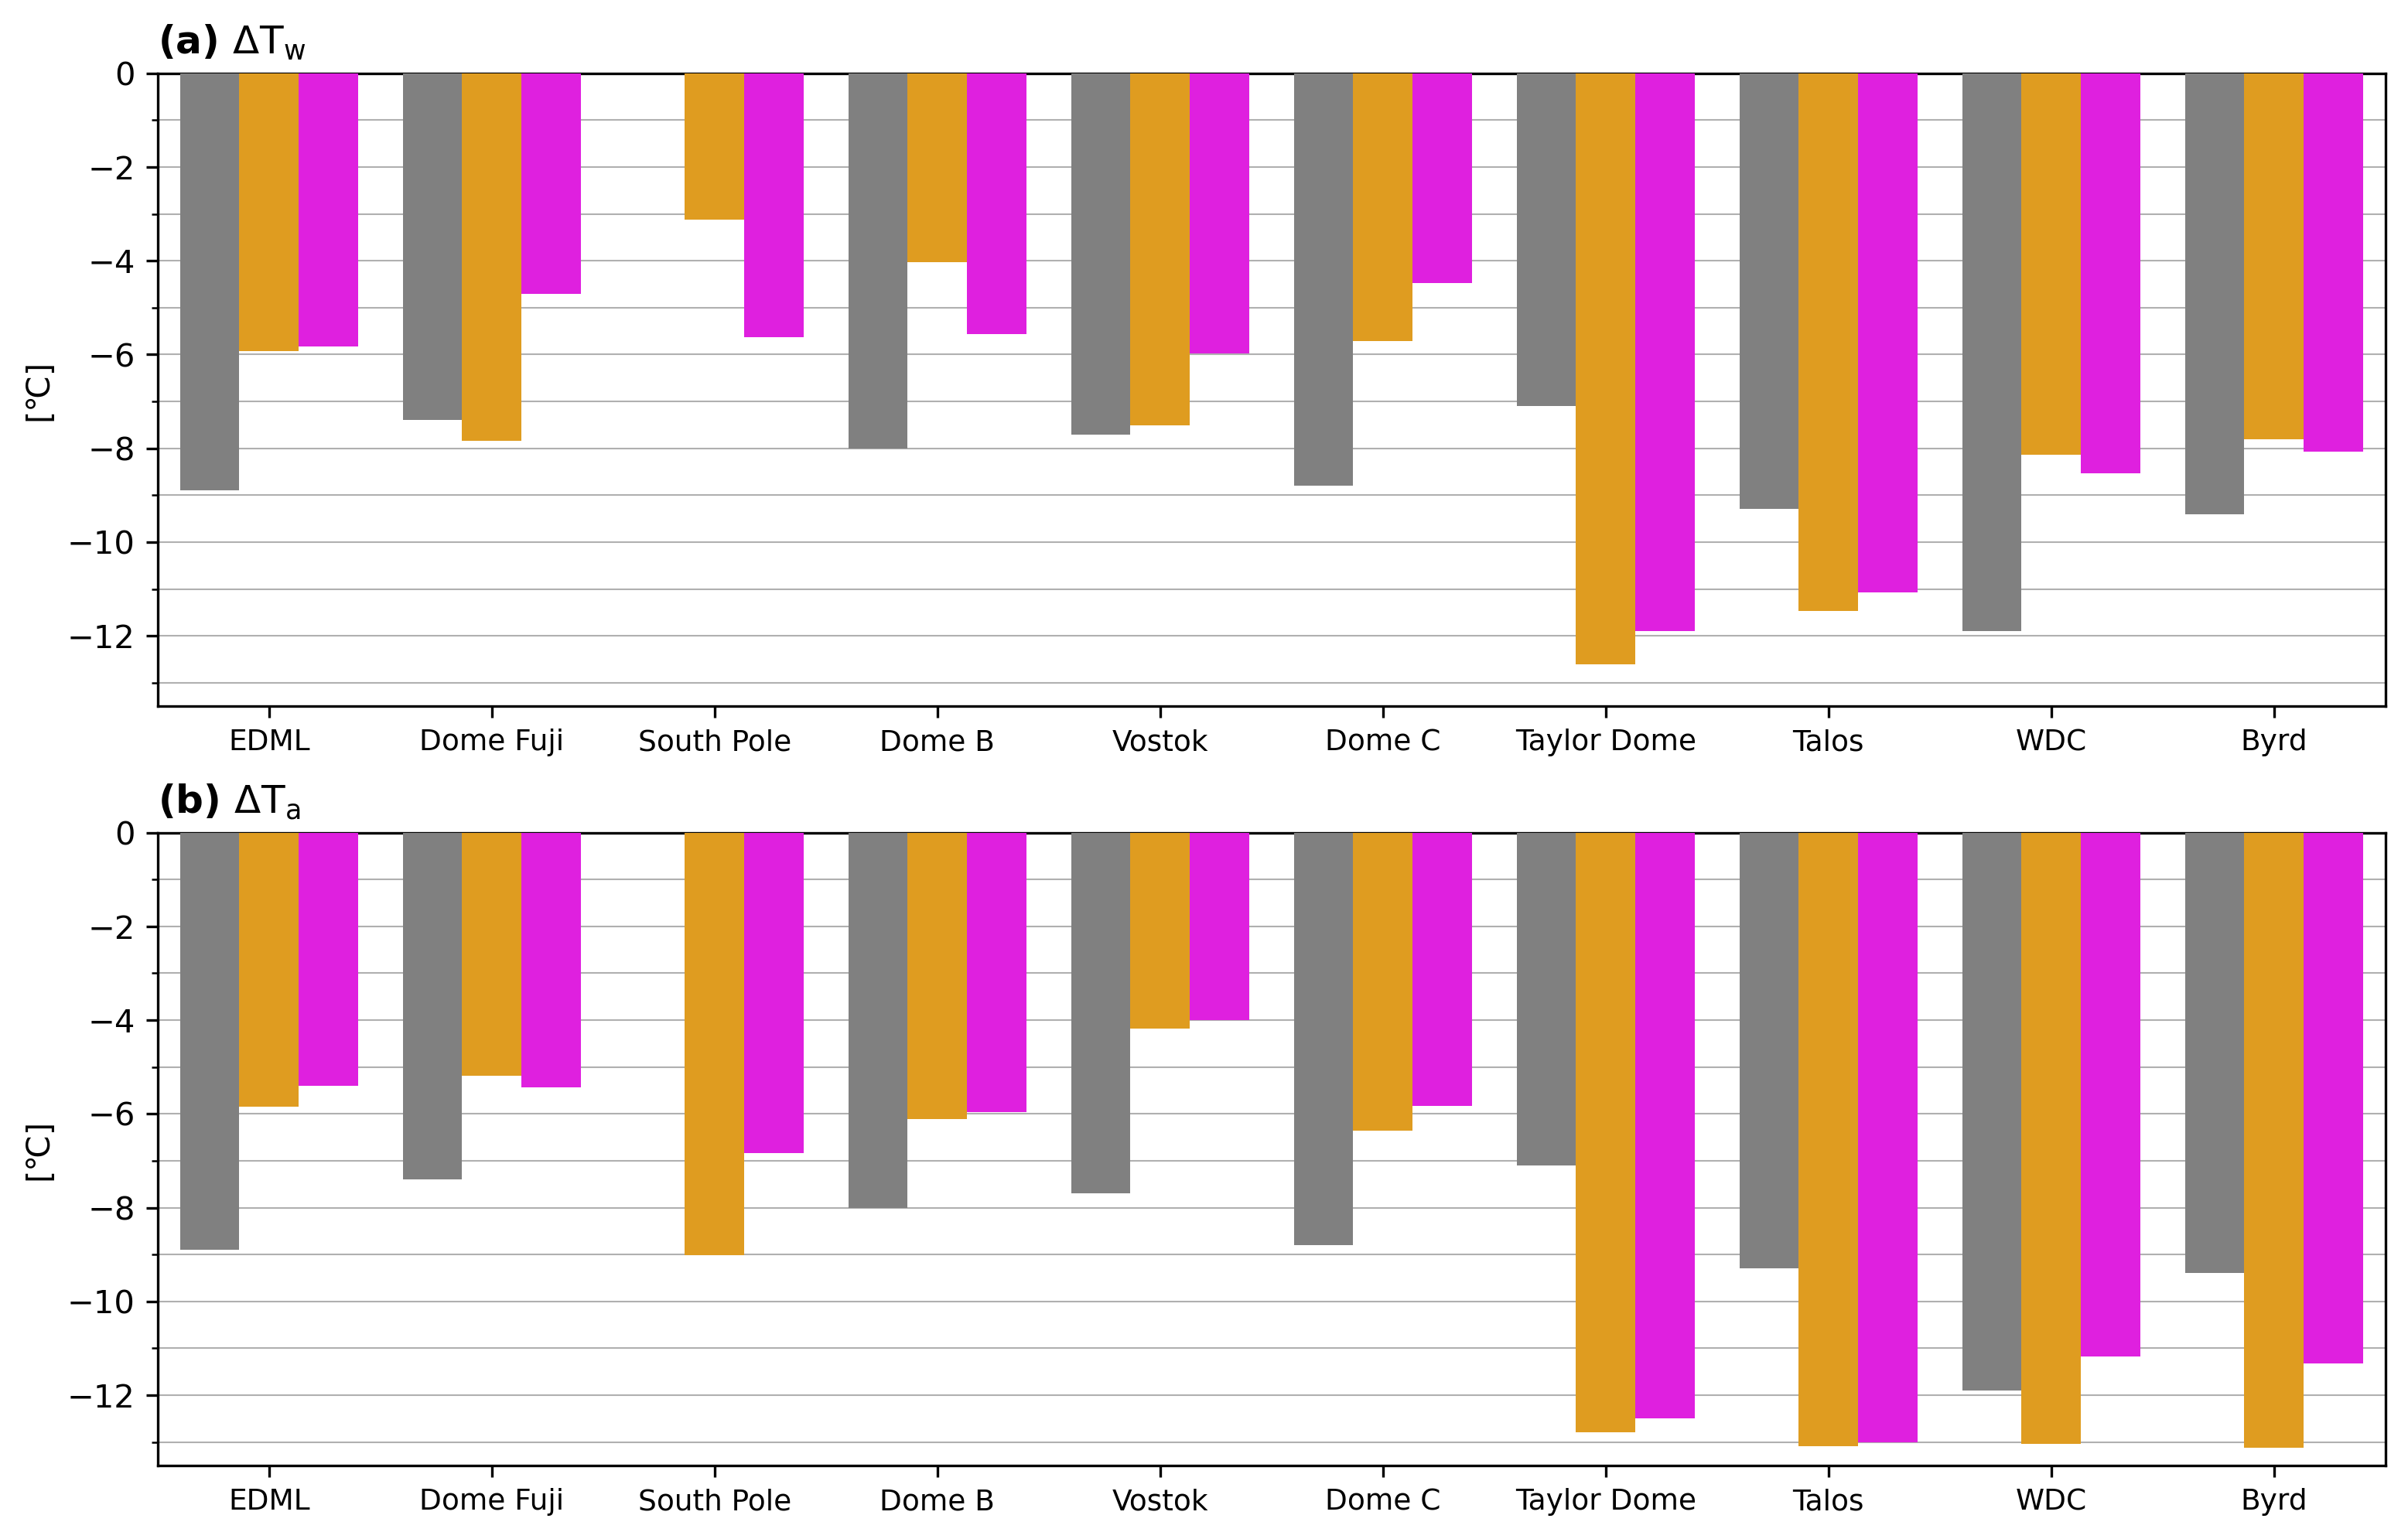

In [22]:
# For presentation
fig, ax = plt.subplots(2,1, figsize=(10,6))
#fig, ax = plt.subplots(3,1, figsize=(10,10))
#fig.suptitle(model)

df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_temp, var="mtemp_w", varo="dtemp")

ax[0].set_title("(a) $\mathsf{\Delta T_w}$",loc="left",weight="demibold")
fig,ax[0] = draw_bar("mtemp_w",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[0],ylim=(-13.5,0),legend=False)


df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_temp, var="mtemp_a", varo="dtemp")

ax[1].set_title("(b) $\mathsf{\Delta T_a}$",loc="left",weight="demibold")
fig,ax[1] = draw_bar("mtemp_a",df_combined[df_combined["label"]!="LGM_Mw/Gice - PI"], palette=colors_LGM_PI, return_fig=True,fig=fig,ax=ax[1],ylim=(-13.5,0),legend=False)

plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.2,wspace=0.05)

plt.show()

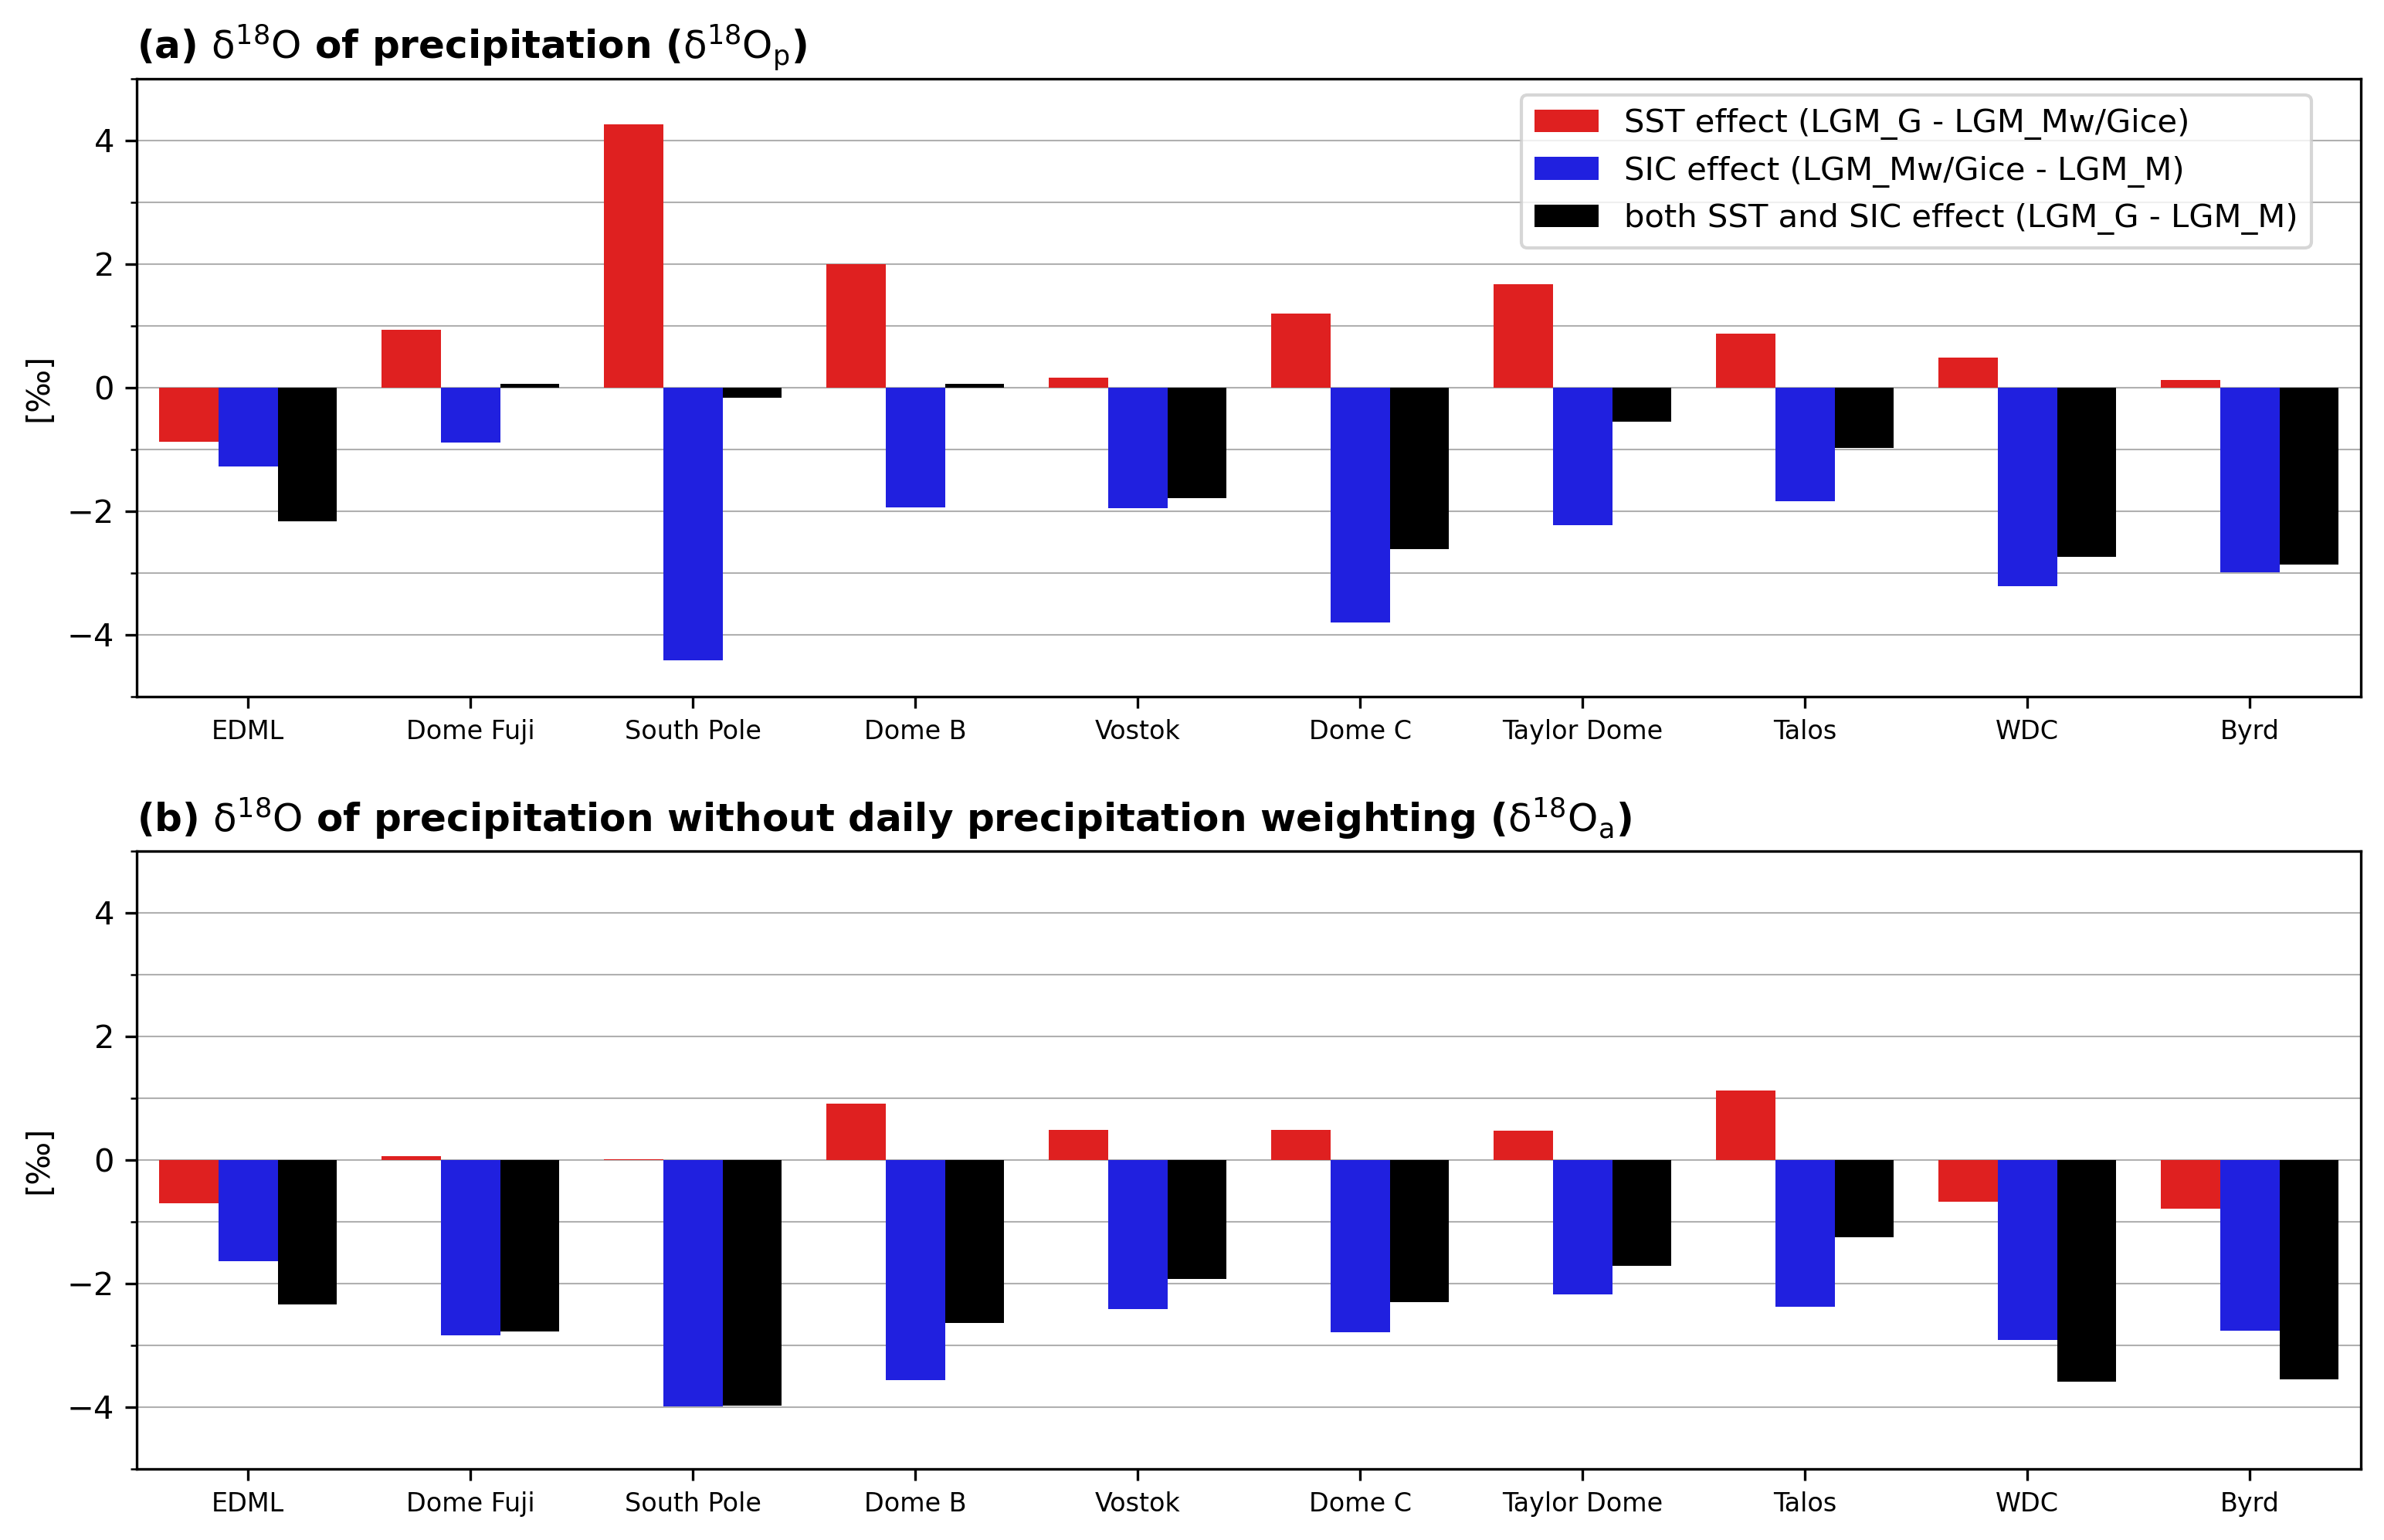

In [23]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
#fig, ax = plt.subplots(3,1, figsize=(10,10))
#fig.suptitle(model)


_,_, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")

ax[0].set_title("(a) $\mathrm{\delta^{18}O}$ of precipitation ($\mathrm{\delta^{18}O_{p}}$)",loc="left",weight="demibold")
fig,ax[0] = draw_bar("md18O_w",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[0],legend_ncol=1, bbox_to_anchor=(0.8, 0.7),ylim=(-5,5),x_label_size=8)


_,_, df_model_LGManom_a=make_df(dfs, df_reconst_d18O, var="md18O_a", varo="dd18O")
ax[1].set_title("(b) $\mathrm{\delta^{18}O}$ of precipitation without daily precipitation weighting ($\mathrm{\delta^{18}O_{a}}$)",loc="left",weight="demibold")
fig,ax[1] = draw_bar("md18O_a",df_model_LGManom_a, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[1], legend=False,ylim=(-5,5),x_label_size=8)


# df_model_LGManom["md18O_diff"]=df_model_LGManom["md18O_w"]-df_model_LGManom_a["md18O_a"]
# ax[2].set_title("(c)",loc="left",weight="demibold")
# fig,ax[2] = draw_bar("md18O_diff",df_model_LGManom, palette=colors_LGM_LGM, return_fig=True,fig=fig,ax=ax[2], bbox_to_anchor=(.5, -0.3),ylim=(-5,5))

plt.subplots_adjust(top=1,bottom=0,left=0.02,right=0.98,hspace=0.25,wspace=0.1)

plt.show()

## Tables

In [24]:
df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_w", varo="dd18O")
#print("d18Op",df_combined)

In [25]:
df_model_combined, df_combined, df_model_LGManom=make_df(dfs, df_reconst_d18O, var="md18O_a", varo="dd18O")
#print("d18Oa",df_combined)